In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd,nd
import random

In [2]:
# 3.2.1生成数据集
num_inputs= 2
num_examples= 1000
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs))
#features[:,0]截取所有行，0列的元素，获得一个一维行向量,即1x1000
labels = true_w[0] *features[:,0]+true_w[1] * features[:,1]+true_b 
labels +=nd.random.normal(scale=0.01,shape=labels.shape)
features.shape,labels.shape#features为1000x2,labels为1x1000

((1000, 2), (1000,))

In [3]:
features[0],labels[0]

(
 [1.1630785 0.4838046]
 <NDArray 2 @cpu(0)>,
 
 [4.879625]
 <NDArray 1 @cpu(0)>)

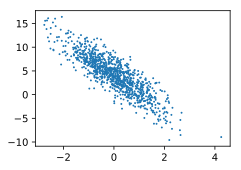

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] =figsize
    
set_figsize()
plt.scatter(features[:,1].asnumpy() , labels.asnumpy(),1);# 加分号只显示图

In [5]:
display.set_matplotlib_formats??

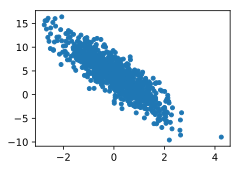

In [6]:
# plt作图函数以及use_svg_display函数和set_figsize函数定义在d2lzh包⾥
import d2lzh as d2l
# 调⽤d2lzh.set_figsize()即可打印⽮量图并设置图的尺⼨为（5，5），默认尺寸为（3.5，2.5） 
d2l.set_figsize((3.5,2.5))
# 'o'为以点的方式连接,marksize为散点的大小
d2l.plt.plot(features[:,1].asnumpy() , labels.asnumpy(),'o',markersize=4);# 加分号只显示图

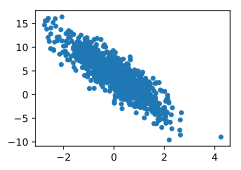

In [7]:
import d2lzh as d2l
d2l.set_figsize((3.5,2.5))
# scatter默认以'o'方式画图，s为散点的大小，s==marksize**2，即marksize=4与s=16的散点大小相同
d2l.plt.scatter(features[:,1].asnumpy() , labels.asnumpy(),s=16);# 加分号只显示图

In [8]:
# help(d2l.plt.plot)

In [9]:
# 3.2.2读取数据
# 本函数已保存在d2lzh包中⽅便以后使⽤
# 此函数每次返回batch_size（批量⼤小）个随机样本的特征和标签 
def data_iter(batch_size, features, labels):
    num_examples =len(features)
    indices =list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # j代表从indices中按照batch_size大小提取的一系列随机排列的索引值
        # min函数保证当样本不能被批量大小整除时，可以返回最后一批次的样本
        j=nd.array(indices[i:min(i + batch_size,num_examples)])
        # take函数根据索引值j获得features和labels中的batch_size数量样本的数据集并返回对应元素
        yield features.take(j),labels.take(j) 

In [10]:
batch_size =10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break


[[-0.85120153 -1.2864591 ]
 [-0.25803244  0.02452744]
 [ 0.6097943   0.10912492]
 [ 0.7328367   2.183979  ]
 [ 0.3480224   0.2528925 ]
 [ 1.1850439   2.1367698 ]
 [-0.2619561   0.21887824]
 [-1.1364244  -0.5422289 ]
 [ 1.9283638   1.104401  ]
 [-1.4933364  -2.392217  ]]
<NDArray 10x2 @cpu(0)> 
[ 6.874958   3.6068153  5.0641456 -1.7546775  4.0320587 -0.7038276
  2.9307134  3.775302   4.2999735  9.34088  ]
<NDArray 10 @cpu(0)>


In [11]:
# 3.2.3初始化模型参数
w = nd.random.normal(scale=0.01,shape=(num_inputs,1))
b = nd.zeros(shape=(1,))
w,b

(
 [[ 0.01464221]
  [-0.01305814]]
 <NDArray 2x1 @cpu(0)>,
 
 [0.]
 <NDArray 1 @cpu(0)>)

In [12]:
# 对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度
w.attach_grad()
b.attach_grad()

In [13]:
# 3.2.4定义模型
# 本函数已保存在d2lzh包中⽅便以后使⽤ 
def linreg(X,w,b):# X为 10x2，w为2x1
    return nd.dot(X,w)+b#return 10x1

In [14]:
# 3.2.5定义损失函数
# 本函数已保存在d2lzh包中⽅便以后使⽤ 
# 模型预测值y_hat,真实值y
def squared_loss(y_hat,y):#y_hat为10x1，y为1x10
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [15]:
# 3.2.6定义优化算法
# 本函数已保存在d2lzh包中⽅便以后使⽤ 
# sgd函数实现了小批量随机梯度下降算法
# lr为学习率，batch_size为批量大小\B\,(lr/\B\)*param.grad为模型参数在本次迭代的减小量
def sgd(params,lr,batch_size):
    for param in params:
        param[:] =param -lr *param.grad /batch_size

In [20]:
# 3.2.7训练模型
#学习率和迭代周期个数均为超参数
lr =0.03 # 学习率
num_epochs = 3 #迭代周期个数
net = linreg #模型,为预测值
loss =squared_loss #损失函数

for epoch in range(num_epochs):# 训练模型⼀共需要num_epochs个迭代周期 
    # 在每⼀个迭代周期中，会使⽤训练数据集中所有样本⼀次（假设样本数能够被批量⼤⼩整除）。
    # X和y分别是⼩批量样本的特征和标签,data_iter为每次返回batch_size大小的数据集
    train_l ,n=0.0,0
    for X,y in data_iter(batch_size,features,labels):
        with autograd.record():
            l = loss(net(X,w,b),y).sum()# l是⼩批量样本关于X和y的loss 
        l.backward() # 对⼩批量样本的损失l求关于模型参数w,b的梯度
        sgd([w,b],lr,batch_size) # 使⽤⼩批量随机梯度下降(sgd)算法迭代模型参数
        train_l +=l.asscalar()
        n+=y.size
    #train_l = loss(net(features, w, b), labels) #一个迭代周期中使用所有样本求得模型参数w，b后的所有样本的loss
    #print( 'epoch %d,loss %f' %( epoch+1,train_l.mean().asnumpy() ) )#mean()求所有数的平均值，并返回只有一个元素NDArray
    print('epoch %d,loss %f' %(epoch+1,train_l/n))

epoch 1,loss 0.000049
epoch 2,loss 0.000049
epoch 3,loss 0.000049


In [ ]:
true_w,w,true_b,b

In [ ]:
# 练习1.为什么squared_loss函数中需要使⽤reshape函数？
# 答：模型预测值y_hat为10x1，真实值y为1x10,故对y用reshape为10x1
    for X,y in data_iter(batch_size,features,labels):
        #with autograd.record():
            #l = loss(net(X,w,b),y)
        print(net(X,w,b),y)
        break

In [ ]:
# 练习2.尝试使⽤不同的学习率，观察损失函数值的下降快慢
# 学习率小时，损失函数下降较快，当在相同迭代次数下，损失函数值较大
# lr=0.01时
# epoch 1,loss 2.186219
# epoch 2,loss 0.287401
# epoch 3,loss 0.038027
# lr=0.03时
# epoch 1,loss 0.035091
# epoch 2,loss 0.000121
# epoch 3,loss 0.000049
# lr=0.05时
# epoch 1,loss 0.000049
# epoch 2,loss 0.000048
# epoch 3,loss 0.000049

In [ ]:
# 练习3.如果样本个数不能被批量⼤小整除，data_iter函数的⾏为会有什么变化？
# 答：当样本个数不能被批量⼤小整除时，min函数保证可以返回最后一批次的样本
#    但是由于batch_size仍为原值(偏大,η/|B|偏小，θ ← θ − （η/|B|）* ∑（ℓ^(i)(θ).grad）)，
#    导致最后一批次的样本的模型参数在sgd梯度下降函数中迭代后的模型参数θ偏大
# 3.2.1生成数据集
num_inputs= 2
num_examples= 19
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs))
labels = true_w[0] *features[:,0]+true_w[1] * features[:,1]+true_b 
labels +=nd.random.normal(scale=0.01,shape=labels.shape)
features.shape,labels.shape
batch_size =10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
